# Musical Instrument Recognition  (Single-Label Classification)

# **Setting**

In [1]:
# download the dataset file
!gdown --id 1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX
# uncompress the zip file
!unzip gct634_nsynth.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX
From (redirected): https://drive.google.com/uc?id=1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX&confirm=t&uuid=079921d2-9653-470e-8c7d-9b51bdbb8b7d
To: /content/gct634_nsynth.zip
100% 130M/130M [00:05<00:00, 22.5MB/s]
Archive:  gct634_nsynth.zip
   creating: gct634_nsynth/
  inflating: __MACOSX/._gct634_nsynth  
   creating: gct634_nsynth/valid/
  inflating: __MACOSX/gct634_nsynth/._valid  
  inflating: gct634_nsynth/valid_list.txt  
  inflating: __MACOSX/gct634_nsynth/._valid_list.txt  
  inflating: gct634_nsynth/train_list.txt  
  inflating: __MACOSX/gct634_nsynth/._train_list.txt  
   creating: gct634_nsynth/train/
  inflating: __MACOSX/gct634_nsynth/._train  
  inflating: gct634_ns

In [130]:
# load libraries
import sys
import os
import gc
import librosa
import scipy
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Change this data path with your own local path
data_path = './gct634_nsynth/'

# path to store MFCC
mfcc_path = './nsynth_features/mfcc/'

SR = 22050
NUM_TRAIN = 1100
NUM_VALID = 300

# **Structure**

In [35]:
def load_audio(dataset='train'):
    f = open(data_path + dataset + '_list.txt','r')

    audio_list = []
    for i, file_name in enumerate(f):
        # progress check
        if not(i%10):
            if dataset == 'train':
              print("\r {:.2f}%".format(i/NUM_TRAIN*100), end='')
            elif dataset == 'valid':
              print("\r {:.2f}%".format(i/NUM_VALID*100), end='')

        # load audio file
        file_name = file_name.rstrip('\n')
        file_path = data_path + file_name
        y, sr = librosa.load(file_path, sr=SR)
        audio_list.append(y)

    audio_matrix = np.stack(audio_list)
    f.close()
    print()

    return audio_matrix

def extract_features(audio, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=20, feature_list=['mfcc']):

    stft = np.stack([librosa.core.stft(x, n_fft=n_fft, hop_length=hop_length) for x in audio],axis=0)
    magnitude = np.abs(stft)
    power = magnitude**2
    log_spectrogram = np.stack([librosa.amplitude_to_db(x, ref=np.max) for x in magnitude],axis=0)
    mel_basis = librosa.filters.mel(sr=SR, n_fft=n_fft, n_mels=n_mels)
    mel_spectrogram = mel_basis @ power
    log_mel_spectrogram = np.stack([librosa.power_to_db(x) for x in mel_spectrogram],axis=0)
    mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=n_mfcc)

    output_list = []
    for feature_type in feature_list:
        if feature_type == 'magnitude':
            output = magnitude
        elif feature_type == 'power':
            output = power
        elif feature_type == 'log_spectrogram':
            output = log_spectrogram
        elif feature_type == 'mel_spectrogram':
            output = mel_spectrogram
        elif feature_type == 'log_mel_spectrogram':
            output = log_mel_spectrogram
        elif feature_type == 'mfcc':
            output = mfcc
        elif feature_type == 'delta_mfcc':
            output = librosa.feature.delta(mfcc)
        elif feature_type == 'double_delta_mfcc':
            output = librosa.feature.delta(mfcc, order=2)
        elif feature_type == 'spectral_centroid':
            output = librosa.feature.spectral_centroid(S=magnitude)
        elif feature_type == 'spectral_bandwidth':
            output = librosa.feature.spectral_bandwidth(S=magnitude)
        elif feature_type == 'spectral_flatness':
            output = librosa.feature.spectral_flatness(S=magnitude)
        elif feature_type == 'envelope':
            envelope = abs(scipy.signal.hilbert(audio))
            output = np.expand_dims(scipy.signal.resample(envelope, audio.shape[-1]//n_fft*2+1,axis=1),axis=1)
        else:
            print(f"Invalid feature_type '{feature_type}'.")
        output_list.append(output)
        # print(f"{output.shape}\t{feature_type}")

    return output_list



def compress(dataset, compression='mean', compression_rate=1.0, axis=2, model=None):
    if axis==0:
        dataset = dataset.reshape(dataset.shape[0], -1)
        axis = 1

    input_dim=dataset.shape[axis]
    output_dim=max(int(input_dim*(1-compression_rate)),1)
    pooling_size = int(np.ceil(input_dim / output_dim))
    output_shape = dataset.shape[:axis] + (-1,) + dataset.shape[axis + 1:]

    if compression == 'mean':
        if input_dim % pooling_size != 0:
            pad = pooling_size - (input_dim % pooling_size)
            dataset = np.pad(dataset, [(0, 0)] * axis + [(0, pad)] + [(0, 0)] * (dataset.ndim - axis - 1), mode='mean')
        shape = dataset.shape[:axis] + (pooling_size, dataset.shape[axis] // pooling_size) + dataset.shape[axis + 1:]
        dataset = dataset.reshape(shape)
        dataset = np.mean(dataset, axis=axis)
    elif compression == 'max':
        if input_dim % pooling_size != 0:
            pad = pooling_size - (input_dim % pooling_size)
            dataset = np.pad(dataset, [(0, 0)] * axis + [(0, pad)] + [(0, 0)] * (dataset.ndim - axis - 1), mode='maximum')
        shape = dataset.shape[:axis] + (pooling_size, dataset.shape[axis] // pooling_size) + dataset.shape[axis + 1:]
        dataset = dataset.reshape(shape)
        dataset = np.max(dataset, axis=axis)
    elif compression == 'pca':
        dataset = dataset.astype(np.float32)
        if model is None:
            output_dim = min(dataset.shape[0], output_dim)
            dataset = dataset.reshape(-1, dataset.shape[axis])
            pca = sklearn.decomposition.TruncatedSVD(n_components=output_dim)
            dataset = pca.fit_transform(dataset)
            dataset = dataset.reshape(output_shape)
            return dataset, pca
        else:
            dataset = dataset.reshape(-1, dataset.shape[axis])
            dataset = model.transform(dataset)
            dataset = dataset.reshape(output_shape)
            return dataset, model
    elif compression == 'k_means':
        dataset = dataset.astype(np.float32)
        if model is None:
            output_dim = min(dataset.shape[0], output_dim)
            dataset = dataset.reshape(-1, dataset.shape[axis])
            kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=output_dim, max_iter=1, n_init=1, init='k-means++')
            dataset = kmeans.fit_transform(dataset)
            dataset = dataset.reshape(output_shape)
            return dataset, kmeans
        else:
            dataset = dataset.reshape(-1, dataset.shape[axis])
            dataset = model.transform(dataset)
            dataset = dataset.reshape(output_shape)
            return dataset, model
    elif compression is not None:
        print(f"Invalid compression method '{compression}'.")

    return dataset


def process_extracted_features(feature_list, compression='mean', compression_rate=1.0, axis=2, model=None):
    dataset = np.concatenate(feature_list, axis=1)
    if compression in ['pca','k_means']:
        dataset, model = compress(dataset, compression, compression_rate, axis, model)
    else:
        dataset = compress(dataset, compression, compression_rate, axis, model)
    dataset = dataset.reshape(len(dataset),-1)
    dataset = (dataset - np.mean(dataset, axis=0)) / (np.std(dataset, axis=0) + 1e-5)

    if compression in ['pca','k_means']:
        return dataset, model
    else:
        return dataset


def preprocess(raw, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=20, feature_list=['mfcc'], compression='mean', compression_rate=1.0, axis=2, model=None):

    output_list = extract_features(raw, n_fft, hop_length, n_mels, n_mfcc, feature_list)
    if not output_list:
        return ValueError(f"Empty feature list.")
    dataset = process_extracted_features(output_list, compression, compression_rate, axis, model)
    return dataset



class Model():
    def __init__(self, model, **kparams):
        if model == 'knn':
            self.model = sklearn.neighbors.KNeighborsClassifier(**kparams)
        elif model == 'logistic_regression':
            self.model = sklearn.linear_model.LogisticRegression(**kparams)
        elif model == 'svm':
            self.model = sklearn.linear_model.SGDClassifier(**kparams)
        elif model == 'mlp':
            self.model = sklearn.neural_network.MLPClassifier(**kparams)
        elif model == 'gmm':
            self.model = sklearn.mixture.GaussianMixture(**kparams)
        elif model == 'random_forest':
            self.model = sklearn.ensemble.RandomForestClassifier(**kparams)

    def train(self, train_X, train_Y):
        if isinstance(self.model, sklearn.mixture.GaussianMixture):
            self.model.fit(train_X)
        else:
            self.model.fit(train_X, train_Y)

    def valid(self, valid_X, valid_Y):
        pred_Y = self.model.predict(valid_X)
        return np.sum((pred_Y == valid_Y))/NUM_VALID*100.0

    def run_experiment(self, train_X, train_Y, valid_X, valid_Y):
        self.train(train_X, train_Y)
        accuracy = self.valid(valid_X, valid_Y)
        return accuracy

# **Baseline**

In [4]:
# load raw data
train_raw = load_audio('train')
valid_raw = load_audio('valid')
# label generation
cls = np.array([1,2,3,4,5,6,7,8,9,10])
train_Y = np.repeat(cls, int(NUM_TRAIN/10))
valid_Y = np.repeat(cls, int(NUM_VALID/10))

 99.09%
 96.67%


In [6]:
# Baseline Test
train_X = preprocess(train_raw)
valid_X = preprocess(valid_raw)
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

valid_acc = []

for a in alphas:
  model = Model(model='svm',verbose=0, loss="hinge", alpha=a, max_iter=1000, penalty="l2", random_state=0)
  acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)
  valid_acc.append(acc)

  print(f'alpha={a:.4f}, validation acc={acc:.2f}%')

print(f'Best validation acc={max(valid_acc):.2f}%')

alpha=0.0001, validation acc=68.33%
alpha=0.0010, validation acc=72.00%
alpha=0.0100, validation acc=71.67%
alpha=0.1000, validation acc=68.67%
alpha=1.0000, validation acc=59.67%
Best validation acc=72.00%


The baseline accuracy has subtle difference from the given one, but the difference can be reasonably explained by precision errors in the calculation process.

# **Data Analysis**

The length of all audio files is identical at 88200 samples :

In [7]:
print(all(
    librosa.load(data_path + file_name[:-1], sr=22050)[0].shape[0] == 88200
    for file_name in open(data_path + 'train_list.txt','r')
))
print(all(
    librosa.load(data_path + file_name[:-1], sr=22050)[0].shape[0] == 88200
    for file_name in open(data_path + 'valid_list.txt','r')
))

True
True


Plot waveforms and mel spectrograms for each class :

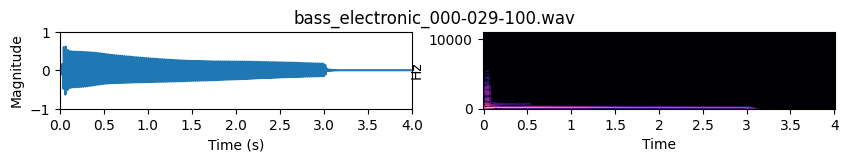

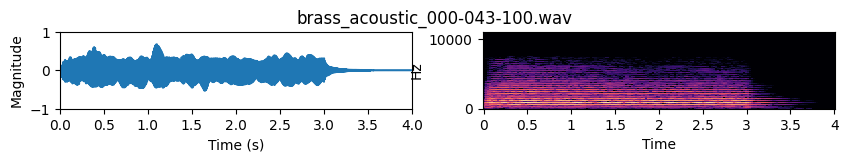

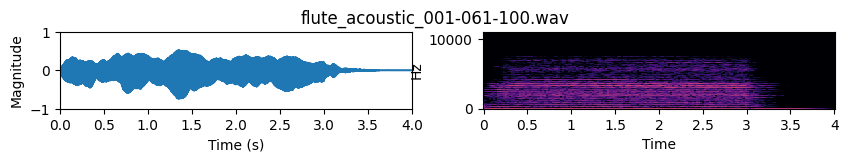

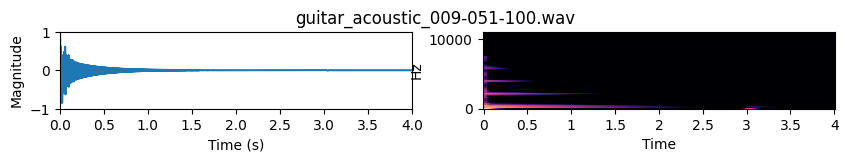

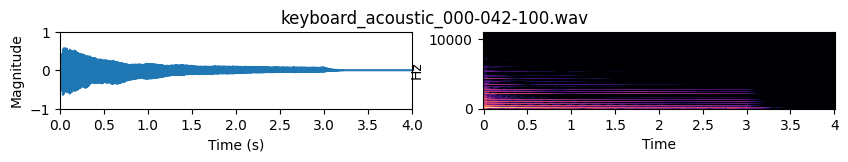

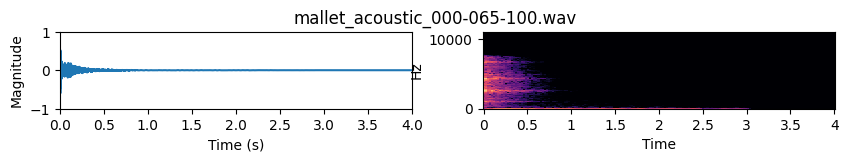

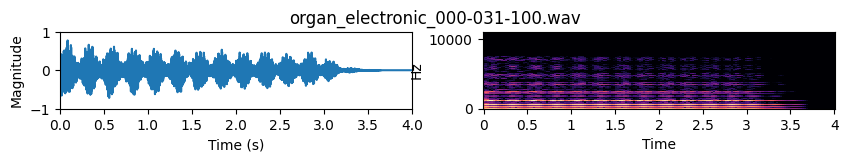

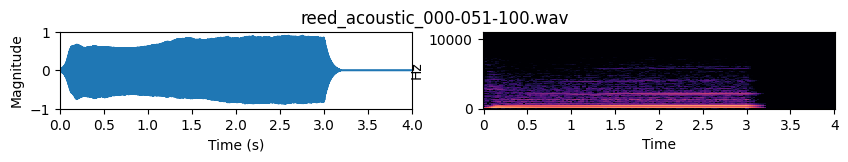

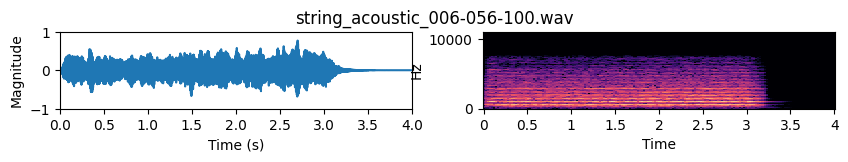

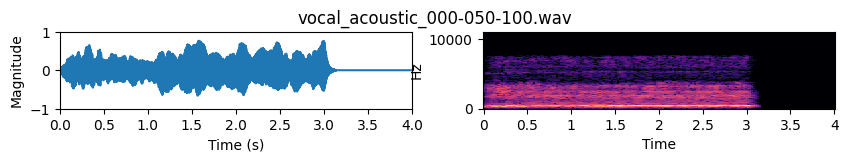

In [8]:
train_path = '/content/gct634_nsynth/train/'
sample_paths = [
    'bass_electronic_000-029-100.wav',
    'brass_acoustic_000-043-100.wav',
    'flute_acoustic_001-061-100.wav',
    'guitar_acoustic_009-051-100.wav',
    'keyboard_acoustic_000-042-100.wav',
    'mallet_acoustic_000-065-100.wav',
    'organ_electronic_000-031-100.wav',
    'reed_acoustic_000-051-100.wav',
    'string_acoustic_006-056-100.wav',
    'vocal_acoustic_000-050-100.wav'
]

for i, file_path in enumerate(sample_paths):
  # Make new plot
  plt.subplots(1, 2, figsize=(10, 1))
  plt.suptitle(f"{file_path}", y=1.1)

  # Load audio
  y, sr = librosa.load(train_path + file_path, sr=SR)
  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

  # Waveform plot
  plt.subplot(1,2,1)
  plt.plot(np.arange(len(y)) / sr, y)
  plt.xlim(0, len(y)/sr)
  plt.ylim(-1, 1)
  plt.xlabel("Time (s)")
  plt.ylabel("Magnitude")

  # Spectrogram plot
  plt.subplot(1,2,2)
  librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear')

  plt.show()


All samples are distinguishable by their shape.

Considerations based on the visualization results:

*   There are distinct changes over time, but the original code only utilizes a single mean value across the entire time axis.
*   Thin wiggling line patterns in the spectrogram plot indicate that the frequency resolution needs to be sufficiently high.

Plot all types of spectrograms :

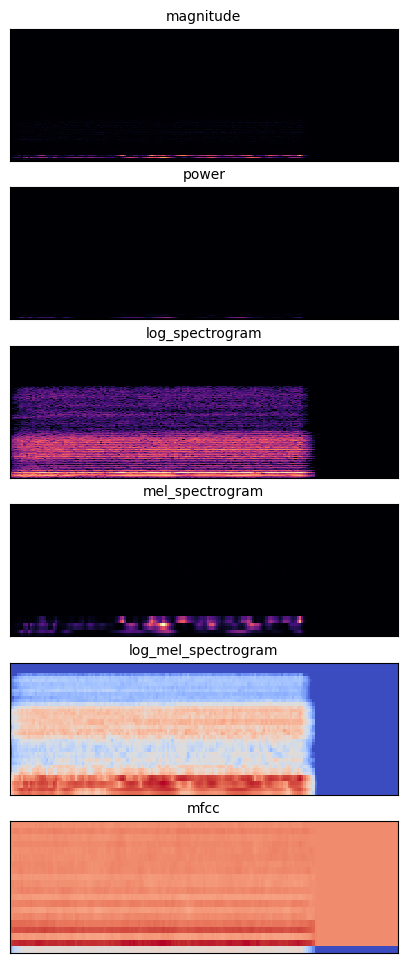

In [9]:
# Raw
audio, sr = librosa.load(train_path + file_path, sr=22050)

# STFT
stft = librosa.core.stft(audio, n_fft=1024, hop_length=512, win_length=1024)

# Complex -> Magnitude
magnitude = np.abs(stft)
power = magnitude**2

# mel filter
mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
mel_spectrogram = np.dot(mel_basis, power)

# log compression
log_spectrogram = librosa.amplitude_to_db(magnitude, ref=np.max)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# DCT
mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=20)

# Plot
elements = {
    'magnitude':magnitude,
    'power':power,
    'log_spectrogram':log_spectrogram,
    'mel_spectrogram':mel_spectrogram,
    'log_mel_spectrogram':log_mel_spectrogram,
    'mfcc':mfcc
}
plt.subplots(len(elements), 1, figsize=(5, len(elements)*2))
for i, (name, val) in enumerate(elements.items()):
    plt.subplot(len(elements),1,i+1);

    librosa.display.specshow(val,  sr=sr)
    plt.title(name,fontdict={'fontsize':10})




Considerations based on the visualization results:

*   Log spectrogram appears to contain the most visual information, which suggests it may also preserve the most audio information.
*   Log scale expands the details, making them more visible.
*   MFCC appears to be effective for compression but have significant information loss.

# **Hypothesis**

> 1. Higher resolution in both time and frequency will improve performance.
> 2. Features that are more visually distinguishable in images will also have better performance, with the log spectrogram being the most effective, the log scale outperforming the linear scale, and MFCC showing weaker performance.
> 3. Compression methods that preserve time information will yield better performance.

# **Experiments**


## **1. Audio Features**

※ Experiment Variables

STFT Parameter

*   stft resolution (n_fft = 512, 1024, 2048)
*   time resolution (hop_length = n_fft/4, n_fft/2, n_fft)
*   mel-bin size (n_mels = 32, 64, 128)
*   DCT size (n_mfcc = 10, 20, 40)

Features
*   Magnitude
*   Power
*   Log_spectrogram
*   Mel_spectrogram
*   Log_mel_spectrogram
*   MFCC
*   delta MFCC
*   double-delta MFCC
*   spectral centroid
*   spectral bandwidth
*   spectral flatness
*   temporal envelope

\\

Since n_fft means the length of the FFT window, and the win_length means the length of the windowing size, it is set to win_length = n_fft

Also since the task is to classify the audio based on timbre, features related to pitch / tonal or rhythmic characteristics will not be considered.

### i. Single audio feature comparison


#### Data collection

In [5]:
# Experiment Variables
parameters = {
    'n_fft':[512,1024,2048],
    'hop_length_division':[4,2,1],
    'n_mels':[32,64,128],
    'n_mfcc':[10,20,40]
}
feature_list=[
    'magnitude',
    'power',
    'log_spectrogram',
    'mel_spectrogram',
    'log_mel_spectrogram',
    'mfcc',
    'delta_mfcc',
    'double_delta_mfcc',
    'spectral_centroid',
    'spectral_bandwidth',
    'spectral_flatness',
    'envelope',
]

In [11]:
# Run experiments
valid_acc = []
model = Model(model='svm',verbose=0, loss="hinge", alpha=0.001, max_iter=1000, penalty="l2", random_state=0)
for n_fft, hop_length_division, n_mels, n_mfcc in itertools.product(*parameters.values()):
    train_features = extract_features(train_raw, n_fft=n_fft, hop_length=n_fft//hop_length_division, n_mels=n_mels, n_mfcc=n_mfcc, feature_list=feature_list)
    valid_features = extract_features(valid_raw, n_fft=n_fft, hop_length=n_fft//hop_length_division, n_mels=n_mels, n_mfcc=n_mfcc, feature_list=feature_list)

    for i, feature in enumerate(feature_list):
        train_X = process_extracted_features([train_features[i]])
        valid_X = process_extracted_features([valid_features[i]])
        acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)

        valid_acc.append(acc)
        print(f'validation acc={acc:.2f}%\tn_fft={n_fft},hop_length={n_fft//hop_length_division},n_mels={n_mels},n_mfcc={n_mfcc}, {feature}')

    del train_features, valid_features

# Save results
feature_acc = np.array(valid_acc).reshape(len(parameters['n_fft']),len(parameters['hop_length_division']),len(parameters['n_mels']),len(parameters['n_mfcc']),len(feature_list))
np.save('./feature_acc.npy',feature_acc)

validation acc=57.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, magnitude
validation acc=48.00%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, power
validation acc=63.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, log_spectrogram
validation acc=48.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, mel_spectrogram
validation acc=63.67%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, log_mel_spectrogram
validation acc=66.00%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, mfcc
validation acc=63.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, delta_mfcc
validation acc=36.67%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, double_delta_mfcc
validation acc=15.00%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, spectral_centroid
validation acc=16.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, spectral_bandwidth
validation acc=20.33%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, spectral_flatness
validation acc=20.00%	n_fft=512,hop_length=128,n_mels=32,n_mfcc=10, envelope
validation acc=57.

#### Data processing

In [12]:
# Load data
feature_acc = np.load('./feature_acc.npy',allow_pickle=True)

# 데이터를 펼쳐서 DataFrame 형태로 변환
data_list = []
for i, j, k, l, m in itertools.product(range(3), range(3), range(3), range(3), range(12)):
    data_list.append([
        parameters['n_fft'][i],
        parameters['hop_length_division'][j],
        parameters['n_mels'][k],
        parameters['n_mfcc'][l],
        feature_list[m],
        feature_acc[i, j, k, l, m]
    ])

df = pd.DataFrame(data_list, columns=['n_fft', 'hop_length_division', 'n_mels', 'n_mfcc', 'feature', 'accuracy'])

# Remove redundant data
df.loc[df['feature'] == 'envelope','hop_length_division':'n_mfcc'] = np.nan
df.loc[df['feature'].isin(['magnitude','power','log_spectrogram']),'n_mels':'n_mfcc'] = np.nan
df.loc[df['feature'].isin(['mel_spectrogram','log_mel_spectrogram']), 'n_mfcc'] = np.nan
df = df.drop_duplicates()

# Print best accuracy with arguments
best = df.loc[df['accuracy'].idxmax()]
print(f'Best validation acc={best["accuracy"]:.2f}%')
print(*best['n_fft':'feature'])

Best validation acc=77.33%
2048 2.0 nan nan log_spectrogram


#### Visualization

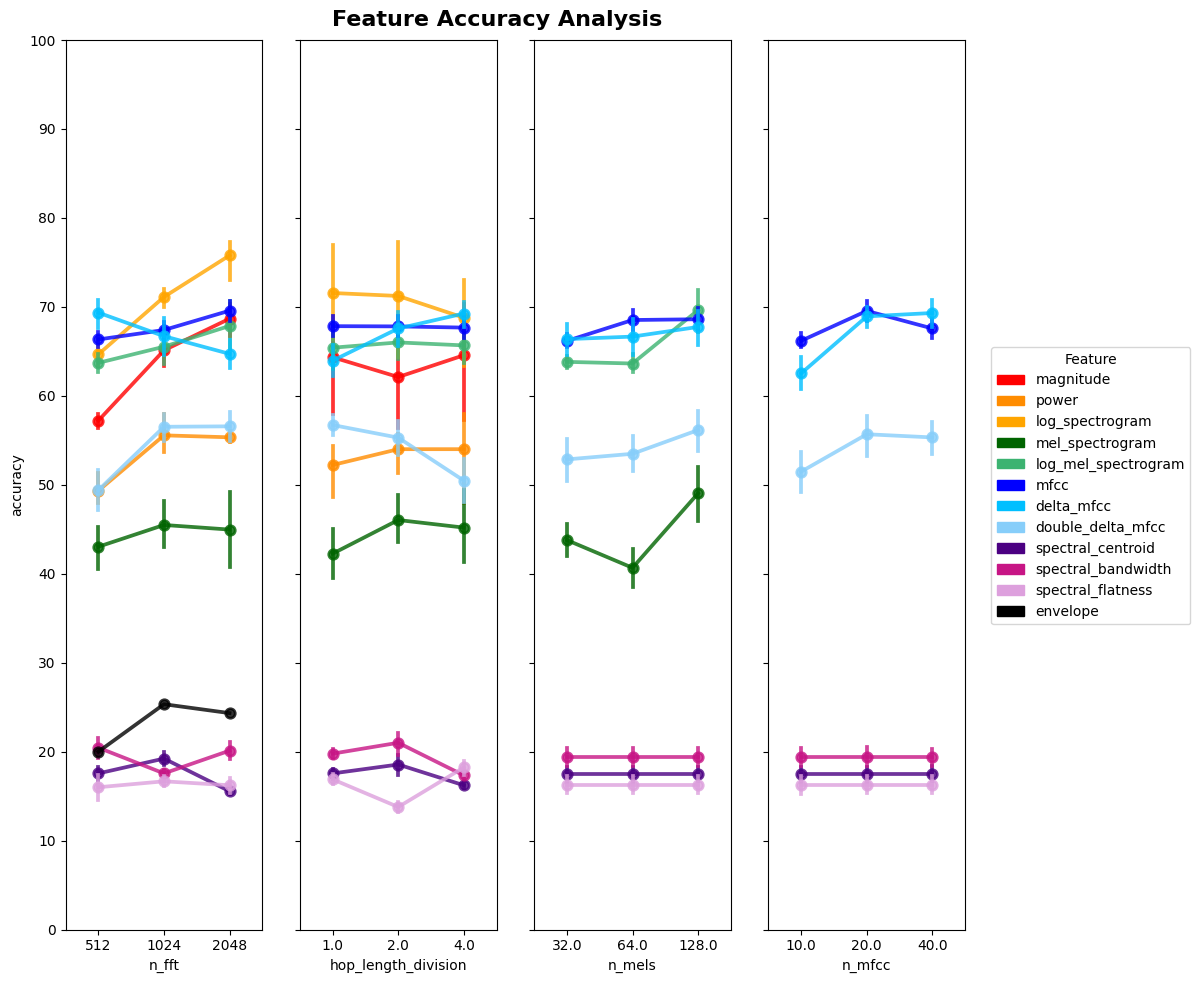

In [13]:
# color setting
feature_order = df["feature"].dropna().unique()
palette = sns.color_palette(["r", "darkorange", "orange", "darkgreen", "mediumseagreen", "b", "deepskyblue", "lightskyblue", "indigo", "mediumvioletred", "plum", "black"])
# grid
grid = sns.PairGrid(df,x_vars=df.columns[:-2],y_vars="accuracy",height=10, aspect=.25)
# plots
for ax, x_var in zip(grid.axes.flat, df.columns[:-2]):
    filtered_data = df.dropna(subset=[x_var, "accuracy"])
    sns.pointplot(
        x=x_var, y="accuracy", hue="feature", data=filtered_data,
        hue_order=feature_order, palette=palette,
        alpha=.8, ax=ax, legend=False
    )
# yticks
grid.set(ylim=(0, 100))
plt.yticks(range(0, 110, 10))
# legend
legend_patches = [Patch(color=palette[i], label=feature) for i, feature in enumerate(feature_order)]
grid.fig.legend(handles=legend_patches, title="Feature", bbox_to_anchor=(1.2, 0.65))
# title
plt.suptitle("Feature Accuracy Analysis", fontsize=16, fontweight="bold")
plt.subplots_adjust(top=0.95)
# outline
sns.despine(left=False, bottom=False, right=False, top=False)

plt.show()

#### Result and discussion

1. As the first hypothesis suggests, accuracy generally improves as resolution increases, as observed in parameters n_fft, n_mels, and n_mfcc.
2. However, contrary to the first hypothesis, the accuracy for different hop_length values depends on the feature types.
3. Spectral parameters also align with the first hypothesis, as they summarize all frequency resolution into a single value, which, when combined with mean time-axis-wise compression, results in worse performance.
4. As stated in the second hypothesis, log spectrogram achieves the highest accuracy.
5. As predicted in the second hypothesis, log scale outperforms the linear scale in feature representation.
6. Contrary to the second hypothesis, MFCC still demonstrates a reasonably good performance.

### ii. Audio feature pair comparison

#### Data collection

In [14]:
# Experiment Variables
N = len(feature_list)
model = Model(model='svm',verbose=0, loss="hinge", alpha=0.001, max_iter=1000, penalty="l2", random_state=0)
train_features = extract_features(train_raw, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list)
valid_features = extract_features(valid_raw, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list)

In [15]:
# Run experiments
valid_acc = np.zeros((N,N))
for i1, i2 in itertools.combinations(range(N), 2):
    train_X = process_extracted_features([train_features[i1],train_features[i2]])
    valid_X = process_extracted_features([valid_features[i1],valid_features[i2]])
    acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)
    valid_acc[i1,i2] = acc
    valid_acc[i2,i1] = acc
    print(f'validation acc={acc:.2f}%\t({feature_list[i1]}, {feature_list[i2]})')

del train_features, valid_features, model

# Save results
pair_acc = np.array(valid_acc)
np.save('./pair_acc.npy',pair_acc)

validation acc=74.33%	(magnitude, power)
validation acc=80.00%	(magnitude, log_spectrogram)
validation acc=70.33%	(magnitude, mel_spectrogram)
validation acc=81.33%	(magnitude, log_mel_spectrogram)
validation acc=74.67%	(magnitude, mfcc)
validation acc=84.67%	(magnitude, delta_mfcc)
validation acc=85.33%	(magnitude, double_delta_mfcc)
validation acc=71.67%	(magnitude, spectral_centroid)
validation acc=70.00%	(magnitude, spectral_bandwidth)
validation acc=70.00%	(magnitude, spectral_flatness)
validation acc=70.33%	(magnitude, envelope)
validation acc=78.00%	(power, log_spectrogram)
validation acc=56.33%	(power, mel_spectrogram)
validation acc=78.67%	(power, log_mel_spectrogram)
validation acc=72.33%	(power, mfcc)
validation acc=78.33%	(power, delta_mfcc)
validation acc=74.00%	(power, double_delta_mfcc)
validation acc=57.00%	(power, spectral_centroid)
validation acc=60.00%	(power, spectral_bandwidth)
validation acc=61.00%	(power, spectral_flatness)
validation acc=55.33%	(power, envelope)

#### Data processing

In [16]:
# Load data
pair_acc = np.load('./pair_acc.npy',allow_pickle=True)
for i in range(N):
    pair_acc[i,i] = feature_acc[2,1,2,2,i]
df = pd.DataFrame(pair_acc, index=feature_list, columns=feature_list)
# Print best accuracy with arguments
i1,i2 = np.unravel_index(np.argmax(pair_acc), pair_acc.shape)
print(f'Best validation acc={np.max(pair_acc):.2f}%')
print((feature_list[i1],feature_list[i2]))

Best validation acc=85.67%
('log_spectrogram', 'double_delta_mfcc')


#### Visualization

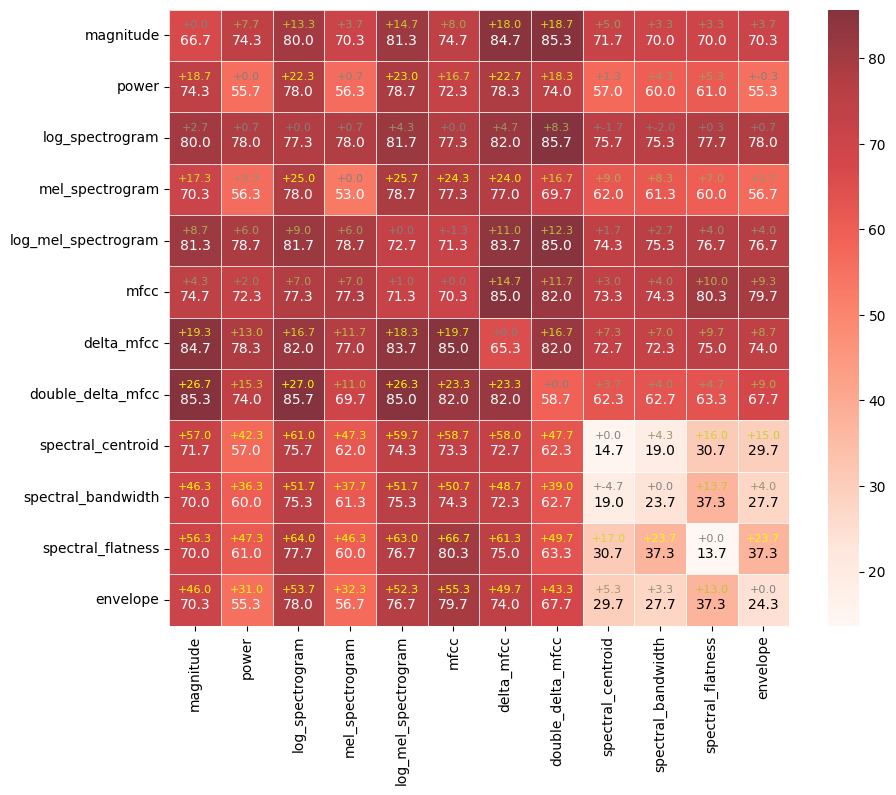

In [17]:
# Plot Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=False, cmap="Reds", linewidths=0.5, alpha=0.8)

# Colormap
cmap = mcolors.LinearSegmentedColormap.from_list("black_yellow", ["gray", "yellow"])
norm = mcolors.Normalize(vmin=0, vmax=25)

# Add delta to text label
for i in range(len(feature_list)):
    for j in range(len(feature_list)):
        value = pair_acc[i, j]
        delta = value - pair_acc[i,i]
        text_color = "black" if value < 50 else "white"
        delta_color = cmap(norm(delta))
        ax.text(j + 0.5, i + 0.6, f"{value:.1f}", fontsize=10, ha="center", va="center", color=text_color)
        ax.text(j + 0.5, i + 0.3, f"+{delta:.1f}", fontsize=8, ha="center", va="center", color=delta_color)


#### Result and discussion

1. The best combination is log spectrogram + double delta MFCC.
2. The results align with previous experiments, where the log spectrogram showed the best performance, and double delta MFCC was the most unrelated feature to the log spectrogram.
3. Spectrogram combinations contain redundancy, and MFCCs are also redundant to each other.
4. Spectral features contribute minimally to any combination.

## **2. Data Compressions**

※ Experiment Variables

Compression method
*   Mean pooling
*   Max pooling
*   PCA

Axis
*   0 (all)
*   1 (feature dimension)
*   2 (time dimension)

Compression ratio
*   0.5
*   0.75
*   1.0


All types of audio feature will be extracted and concatenated to generate features for a comprehensive understanding of compression efficiency.

#### Data collection

In [47]:
# Experiment Variables
compressions=['mean','max','pca']
axis = [0,1,2]
compression_rates = [0.5, 0.75, 1.0]
model = Model(model='svm',verbose=0, loss="hinge", alpha=0.001, max_iter=1000, penalty="l2", random_state=0)
train_features = extract_features(train_raw, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list)
valid_features = extract_features(valid_raw, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list)

In [7]:
# Run experiments
valid_acc = []
for compression in compressions:
    for ax in axis:
        for compression_rate in compression_rates:
            if compression == 'pca':
                train_X, fitted = process_extracted_features(train_features, compression=compression, axis=ax, compression_rate=compression_rate)
                valid_X, fitted = process_extracted_features(valid_features, compression=compression, axis=ax, compression_rate=compression_rate, model=fitted)
            else:
                train_X = process_extracted_features(train_features, compression=compression, axis=ax, compression_rate=compression_rate)
                valid_X = process_extracted_features(valid_features, compression=compression, axis=ax, compression_rate=compression_rate)
            acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)
            valid_acc.append(acc)
            print(f'validation acc={acc:.2f}%\t{compression}, axis={ax}, compression_rate={compression_rate}')
            del train_X, valid_X

# Save results
compression_acc = np.array(valid_acc).reshape(3,3,3)
np.save('./compression_acc.npy',compression_acc)

validation acc=94.67%	mean, axis=0, compression_rate=0.5
validation acc=90.33%	mean, axis=0, compression_rate=0.75
validation acc=19.33%	mean, axis=0, compression_rate=1.0
validation acc=93.00%	mean, axis=1, compression_rate=0.5
validation acc=90.33%	mean, axis=1, compression_rate=0.75
validation acc=55.00%	mean, axis=1, compression_rate=1.0
validation acc=90.67%	mean, axis=2, compression_rate=0.5
validation acc=92.00%	mean, axis=2, compression_rate=0.75
validation acc=88.00%	mean, axis=2, compression_rate=1.0
validation acc=88.33%	max, axis=0, compression_rate=0.5
validation acc=83.33%	max, axis=0, compression_rate=0.75
validation acc=18.33%	max, axis=0, compression_rate=1.0
validation acc=89.33%	max, axis=1, compression_rate=0.5
validation acc=83.33%	max, axis=1, compression_rate=0.75
validation acc=70.00%	max, axis=1, compression_rate=1.0
validation acc=94.00%	max, axis=2, compression_rate=0.5
validation acc=93.67%	max, axis=2, compression_rate=0.75
validation acc=90.33%	max, axis=2

#### Data processing

In [49]:
# Load data
compression_acc = np.load('./compression_acc.npy',allow_pickle=True)

# 데이터를 펼쳐서 DataFrame 형태로 변환
data_list = []
for i, j, k in itertools.product(range(3), range(3), range(3)):
    data_list.append([compressions[i],axis[j],compression_rates[k],compression_acc[i, j, k]])
df = pd.DataFrame(data_list, columns=['compressions', 'axis', 'compression_rates','accuracy'])

# Print best accuracy with arguments
best = df.loc[df['accuracy'].idxmax()]
print(f'Best validation acc={best["accuracy"]:.2f}%')
print(*best['compressions':'compression_rates'])

Best validation acc=95.67%
pca 1 0.75


#### Visualization

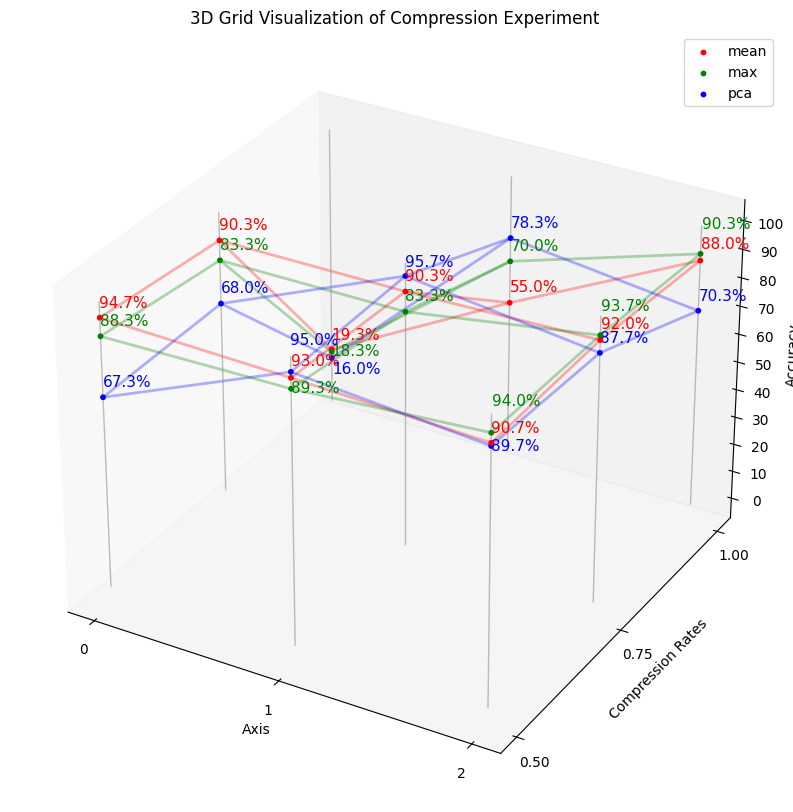

In [244]:
# 색상 매핑
colors = {'mean': 'r', 'max': 'g', 'pca': 'b'}
# 3D 그래프 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# 파라미터
line_alpha = 0.3
line_width = 2
dot_size = 10
dot_alpha = 1

# List to keep track of the used label positions
used_positions = {}
offset = 5
for compression in compressions:
    subset = df[df['compressions'] == compression].sort_values(by=['axis', 'compression_rates'])
    ax.scatter(subset['axis'], subset['compression_rates'], subset['accuracy'],
               c=colors[compression], label=compression, s=dot_size, alpha=dot_alpha)

    # 세로줄
    for rate in compression_rates:
        sub = subset[subset['compression_rates'] == rate].sort_values(by='axis')
        ax.plot(sub['axis'], sub['compression_rates'], sub['accuracy'], c=colors[compression], alpha=line_alpha, linewidth=line_width)
    # 가로줄
    for ax_val in axis:
        sub = subset[subset['axis'] == ax_val].sort_values(by='compression_rates')
        ax.plot(sub['axis'], sub['compression_rates'], sub['accuracy'], c=colors[compression], alpha=line_alpha, linewidth=line_width)

    # 텍스트
    for i in range(len(subset)):
        accuracy = round(subset['accuracy'].iloc[i], 1)
        x_pos = subset['axis'].iloc[i]
        y_pos = subset['compression_rates'].iloc[i]
        z_pos = np.floor(accuracy) + 4  # Default z offset for text
        # Check if the position is already used and adjust accordingly
        while (x_pos, y_pos, z_pos) in used_positions:
            if accuracy < used_positions[(x_pos, y_pos, z_pos)]:
                z_pos -= offset  # Decrease the z offset if the position is already taken
            else:
                z_pos += offset  # Increase the z offset if the position is already taken
        # Add the position to the used positions dictionary
        for i in range(offset):
            used_positions[(x_pos, y_pos, z_pos-i)] = accuracy
            used_positions[(x_pos, y_pos, z_pos+i)] = accuracy
        ax.text(x_pos, y_pos, z_pos, f"{accuracy:.1f}%", color=colors[compression], fontsize=11)

# Each (x, y) intersection: Draw vertical lines in the z direction
for ax_val in axis:
    for rate in compression_rates:
        ax.plot([ax_val, ax_val], [rate, rate], [0, 100], c='gray', alpha=.5, linewidth=1)

# Set custom ticks
ax.set_xticks(axis)
ax.set_yticks(compression_rates)
ax.set_zticks(np.arange(0, 101, 10))
ax.set_xlabel('Axis')
ax.set_ylabel('Compression Rates')
ax.set_zlabel('Accuracy')
ax.set_title('3D Grid Visualization of Compression Experiment')
ax.grid(False)
ax.legend()
plt.show()

#### Result and discussion

1. Mean pooling shows similar performance overall, except at 100% compression, suggesting it behaves like downsampling.
2. Max pooling improves performance when compressing the time dimension, even at 100% compression, suggesting that max frequency values are crucial factors.
3. PCA performs well when reducing the feature dimension, indicating that it effectively characterizes feature information. However, it performs poorly when axis=0, likely due to the constraint that the output dimension cannot exceed the number of samples.
4. All methods struggled when reduced to a single value.
5. Contrary to the third hypothesis, performance degradation from reducing the time dimension depends more on the method and its interaction with the axis, rather than just the axis itself.

## **3. Models**

※ Experiment Variables

Model type
*   k-NN
*   logistic regression
*   SVM
*   MLP
*   Random forest

Parameters for each model are the default values.

The best combination of compression method and feature types from the previous experiment is used.

#### Data collection

In [42]:
# Experiment Variables
models = ['knn', 'logistic_regression', 'svm', 'mlp', 'random_forest']
train_X, comp = preprocess(train_raw, compression='pca', axis=1, compression_rate=0.75, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list)
valid_X, comp = preprocess(valid_raw, compression='pca', axis=1, compression_rate=0.75, n_fft=2048, hop_length=1024, n_mels=128, n_mfcc=40, feature_list=feature_list, model=comp)

In [43]:
# Run experiments
valid_acc = []
for model_name in models:
    model = Model(model_name)
    acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)
    valid_acc.append(acc)
    print(f'validation acc={acc:.2f}%,\tmodel:{model_name}')
    del model

# Save results
model_acc = np.array(valid_acc)
np.save('./model_acc.npy',model_acc)

validation acc=64.00%,	model:knn
validation acc=96.67%,	model:logistic_regression
validation acc=95.00%,	model:svm
validation acc=95.00%,	model:mlp
validation acc=95.00%,	model:random_forest


#### Data processing

In [52]:
# Load saved accuracies
model_acc = np.load('./model_acc.npy')
# Print best accuracy with arguments
print(f'Best validation acc={max(model_acc):.2f}%')
print(models[np.argmax(model_acc)])

Best validation acc=96.67%
logistic_regression


#### Visualization

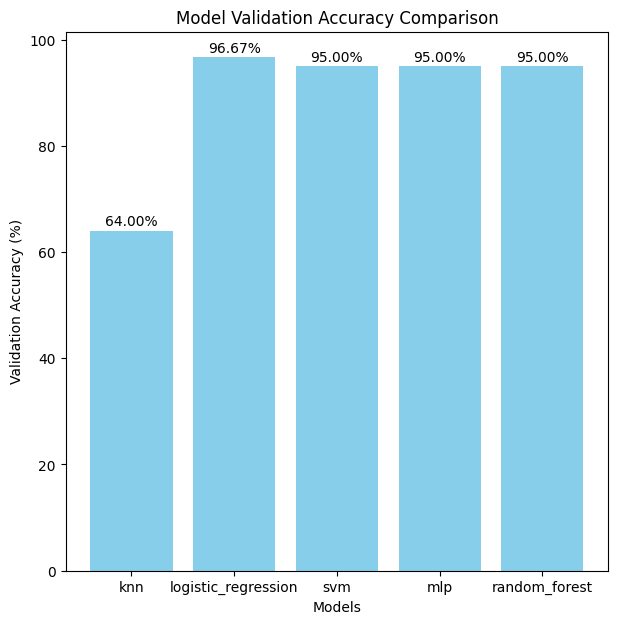

In [44]:
# Create plot
plt.figure(figsize=(7, 7))
plt.bar(models, model_acc, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Validation Accuracy (%)")
plt.title("Model Validation Accuracy Comparison")
# Show values on top of bars
for i, acc in enumerate(model_acc):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)
plt.show()

In [45]:
for i in range(1, 50):
    model = Model('knn', n_neighbors=i)
    acc = model.run_experiment(train_X, train_Y, valid_X, valid_Y)
    print(f'validation acc={acc:.2f}%,\tn_neighbors={i}')

validation acc=82.00%,	n_neighbors=1
validation acc=67.33%,	n_neighbors=2
validation acc=71.00%,	n_neighbors=3
validation acc=67.00%,	n_neighbors=4
validation acc=64.00%,	n_neighbors=5
validation acc=64.00%,	n_neighbors=6
validation acc=61.33%,	n_neighbors=7
validation acc=62.33%,	n_neighbors=8
validation acc=66.33%,	n_neighbors=9
validation acc=65.67%,	n_neighbors=10
validation acc=65.00%,	n_neighbors=11
validation acc=64.00%,	n_neighbors=12
validation acc=64.33%,	n_neighbors=13
validation acc=64.33%,	n_neighbors=14
validation acc=63.00%,	n_neighbors=15
validation acc=62.00%,	n_neighbors=16
validation acc=61.00%,	n_neighbors=17
validation acc=59.33%,	n_neighbors=18
validation acc=59.67%,	n_neighbors=19
validation acc=58.67%,	n_neighbors=20
validation acc=58.00%,	n_neighbors=21
validation acc=57.67%,	n_neighbors=22
validation acc=55.00%,	n_neighbors=23
validation acc=54.00%,	n_neighbors=24
validation acc=52.33%,	n_neighbors=25
validation acc=51.67%,	n_neighbors=26
validation acc=51.00%

#### Result and discussion





1. Logistic regression achieved the highest accuracy at 96.67%.
2. k-NN significantly underperformed compared to other models, and tuning its parameters did not lead to substantial improvement. This suggests that k-NN struggles to capture complex dimensionality of the feature representations effectively.
3. One possibility not explored is that k-NN might perform better with k-means clustering compression, as the data's distance to cluster centroids could align well with k-NN's distance-based classification.

